In [141]:
import pandas as pd
import numpy as np
from typing import Union


from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt

np.set_printoptions(precision=3,suppress=True )

In [24]:
Temp=np.array([-0.4, 0.3, 4.2, 8.3, 13.0, 15.9,18.0, 17.5, 13.4, 8.7, 3.9,  0.6])
Precip=np.array([49, 39, 44, 41, 61, 58, 71, 58, 51,48, 50, 58])
Evp=np.array([12, 18, 35, 58, 82, 90, 97, 84, 54, 31,14, 10])

soil_thick=25  #Soil thickness (organic layer topsoil), in cm
SOC=69.7       #Soil organic carbon in Mg/ha 
clay=48        #Percent clay
Cinputs=2.7   #Annual C inputs to soil in Mg/ha/yr

In [189]:
class RothC:
    
    """
    
    pE - Evaporation coefficient. 
        If open pan evaporation is used pE=0.75.
        If Potential evaporation is used, pE=1.0.
    """
    def __init__(self,
                 temperature: Union[list, np.ndarray],
                 precip: Union[list, np.ndarray],
                 evaporation: Union[list, np.ndarray],
                 years: int = 500, 
                 ks: np.ndarray = np.array([10, 0.3, 0.66, 0.02, 0]), 
                 C0: np.ndarray = np.array([0, 0, 0, 0, 2.7]), 
                 input_carbon: Union[float, np.ndarray] = 1.7, 
                 farmyard_manure: Union[float, np.ndarray] = 0, 
                 clay: float = 23.4,
                 soil_thickness: float = 25.0,
                 DR: float = 1.44,  # ratio DPM/RPM
                 pE:float = 0.75,
                 bare: bool = False,
                 solver: str = 'euler'):
        self.years = years
#         self.t = np.arange(1/12,years,step=1/12)
        self.t = range(12 * years)
        self.ks_pulls = ["DPM","RPM", "BIO", "HUM","IOM"]
        if len(ks) != 5: 
            raise ValueError("ks must be of length = 5")
        self.ks = ks
        if len(C0) != 5: 
            raise ValueError("the vector with initial conditions must be of length = 5")
        self.C0 = C0
        self.farmyard_manure = farmyard_manure
        self.input_carbon = input_carbon
        self.clay = clay
        self.DR = DR
        self.pE = pE
        self.bare = bare
        self.soil_thickness = soil_thickness
        self.solver = solver
        self._t = []
#         self.t_start = min(self.t)
#         self.t_end   = max(self.t)
        
        self.xi = self.get_stress_parameters(temperature=temperature, 
                                            precip=precip, 
                                            evaporation=evaporation)
    
    
    def get_stress_parameters(self, temperature:np.ndarray,
                              precip:np.ndarray,
                              evaporation: np.ndarray):
        stress_temp = self.fT(temperature=temperature)
        acc_TSMD, b = self.fW(precip=precip, 
                            evaporation=evaporation,
                            pE=self.pE,
                            bare=self.bare,
                            clay = self.clay,
                            soil_thickness=self.soil_thickness)
        xi = stress_temp * b 
        xi = np.tile(xi, self.years)
        return xi
    
    
    def fT(self, temperature: list) -> list:
        stress_coef = []
        for x in temperature:
            if x < -18.3:
                stress_coef.append(np.nan)
            else:
                stress_coef.append(47.9 / (1 + np.exp(106 / (x + 18.3))))
        return stress_coef
        
    
    def fW(self,
        precip: np.ndarray,
        evaporation: np.ndarray,
        soil_thickness: float,
        pE: float = 0.75,
        clay: float = 20.0,
        bare: bool = True):
        """
        precip - A vector with monthly precipitation (mm).

        evaporation - A vector with same length with open pan evaporation or
                evapotranspiration (mm).

        S.Thick
        Soil thickness in cm. Default for Rothamsted is 23 cm.

        pClay
        Percent clay.

        pE
        Evaporation coefficient. If open pan evaporation is used pE=0.75. If Potential evaporation is used, pE=1.0.

        bare
        Logical. Under bare soil conditions, bare=TRUE. Default is set under vegetated soil.

        """
        # compute maximum soil moisture defficit 
        if precip.shape != evaporation.shape:
            raise ValueError('Precip and evaporation have different shape')
    #     max_smd = -(20.0 + 1.3 * clay - 0.01 * clay**2)
        max_smd = -(20.0 + 1.3 * clay - 0.01 * clay**2) * (soil_thickness/23) # TO-DO Verify this soil_thik / 23    
        if bare:
            max_smd = max_smd/1.8
        M = precip - evaporation * pE
        acc_TSMD = np.zeros(shape=(len(M)))
        if M[0] > 0:
            acc_TSMD[0] = 0 
        else:
            acc_TSMD[0] = M[0]
        for i in range(1, len(M)):
            if acc_TSMD[i - 1] + M[i] < 0: 
                acc_TSMD[i] = acc_TSMD[i - 1] + M[i]
            else:
                acc_TSMD[i] = 0
            if acc_TSMD[i] <= max_smd:
                acc_TSMD[i] = max_smd
        b = np.zeros(shape=acc_TSMD.shape)
        mask = acc_TSMD > 0.444 * max_smd
        b = 0.2 + 0.8 * ((max_smd - acc_TSMD)/(max_smd - 0.444 * max_smd))
        b[mask]=1
        return acc_TSMD, b
    def get_input_flux(self, input_carbon:float, 
                      farmyard_manure:float=0, 
                       DR: float = 1.44)->np.ndarray:
        """
        input_carbon (float): The plant residue input is the amount of carbon that is put into the soil per month
        farmyard_manure (float): monthly input of farmyard manure (FYM) (t C ha-1),
        DR (float): # ratio DPM/RPM
        """
        gamma = DR/(1+DR)
        input_DPM = input_carbon * gamma + (farmyard_manure * 0.49)
        input_RPM = input_carbon * (1-gamma) + (farmyard_manure * 0.49)
        input_BIO = 0 
        input_HUM = farmyard_manure * 0.02 
        input_IOM = 0
        return np.array([input_DPM, input_RPM, input_BIO, input_HUM, input_IOM])
    def dCdt(self, C, t):
        self._t.append(t)
        ks = self.ks
        x=1.67*(1.85+1.60*np.exp(-0.0786*clay))
        B=0.46/(x+1) 
        H=0.54/(x+1) 
        ai3=B*ks
        ai4=H*ks
        A=np.diag(-ks)
        A[2,]=A[2,]+ai3
        A[3,]=A[3,]+ai4
        
        in_flux = self.get_input_flux(self.input_carbon, self.farmyard_manure, self.DR)
#         print(self.xi[position])
#         C_next = in_flux + (A*self.xi[int(t)]).dot(C)
        C_next = in_flux + (A*self.xi[2]).dot(C)
        return C_next

## Main part

\begin{aligned}
& \frac{d \boldsymbol{C}}{\mathrm{d} t}=I\left(\begin{array}{c}
\gamma \\
1-\gamma \\
0 \\
0 \\
0
\end{array}\right) 
 +\left(\begin{array}{ccccc}
-k_1 & 0 & 0 & 0 & 0 \\
0 & -k_2 & 0 & 0 & 0 \\
a_{3,1} & a_{3,2} & -k_3+a_{3,3} & a_{3,4} & 0 \\
a_{4,1} & a_{4,2} & a_{4,3} & -k_4+a_{4,4} & 0 \\
0 & 0 & 0 & 0 & 0
\end{array}\right)\left(\begin{array}{l}
C_1 \\
C_2 \\
C_3 \\
C_4 \\
C_5
\end{array}\right) \\
&
\end{aligned}

In [190]:
rothC = RothC(temperature=Temp, 
             precip=Precip, 
             evaporation=Evp,
             clay = 48)


y1 = odeint(rothC.dCdt,rothC.C0, t=rothC.t)
# rothC.dCdt(rothC.C0, 2)

In [191]:
df=pd.DataFrame(y1, columns=rothC.ks_pulls)

In [192]:
import seaborn as sns
sns.set_context('talk')

Text(0, 0.5, 'C stocks (Mg/ha)')

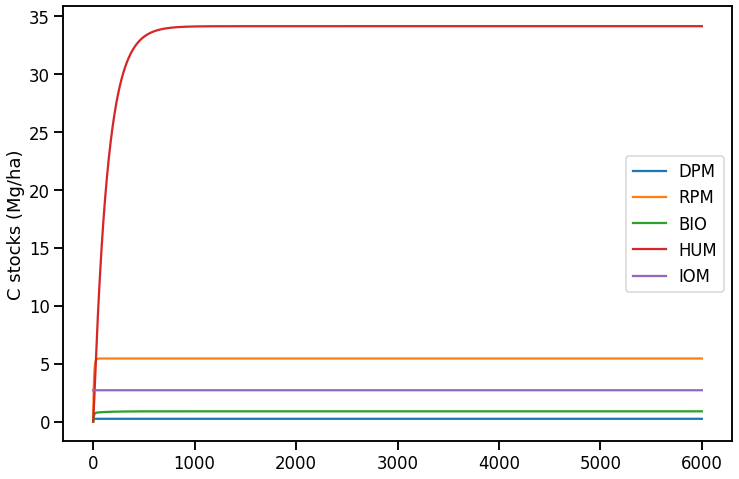

In [193]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
df.plot(ax=ax)
ax.set_ylabel('C stocks (Mg/ha)')

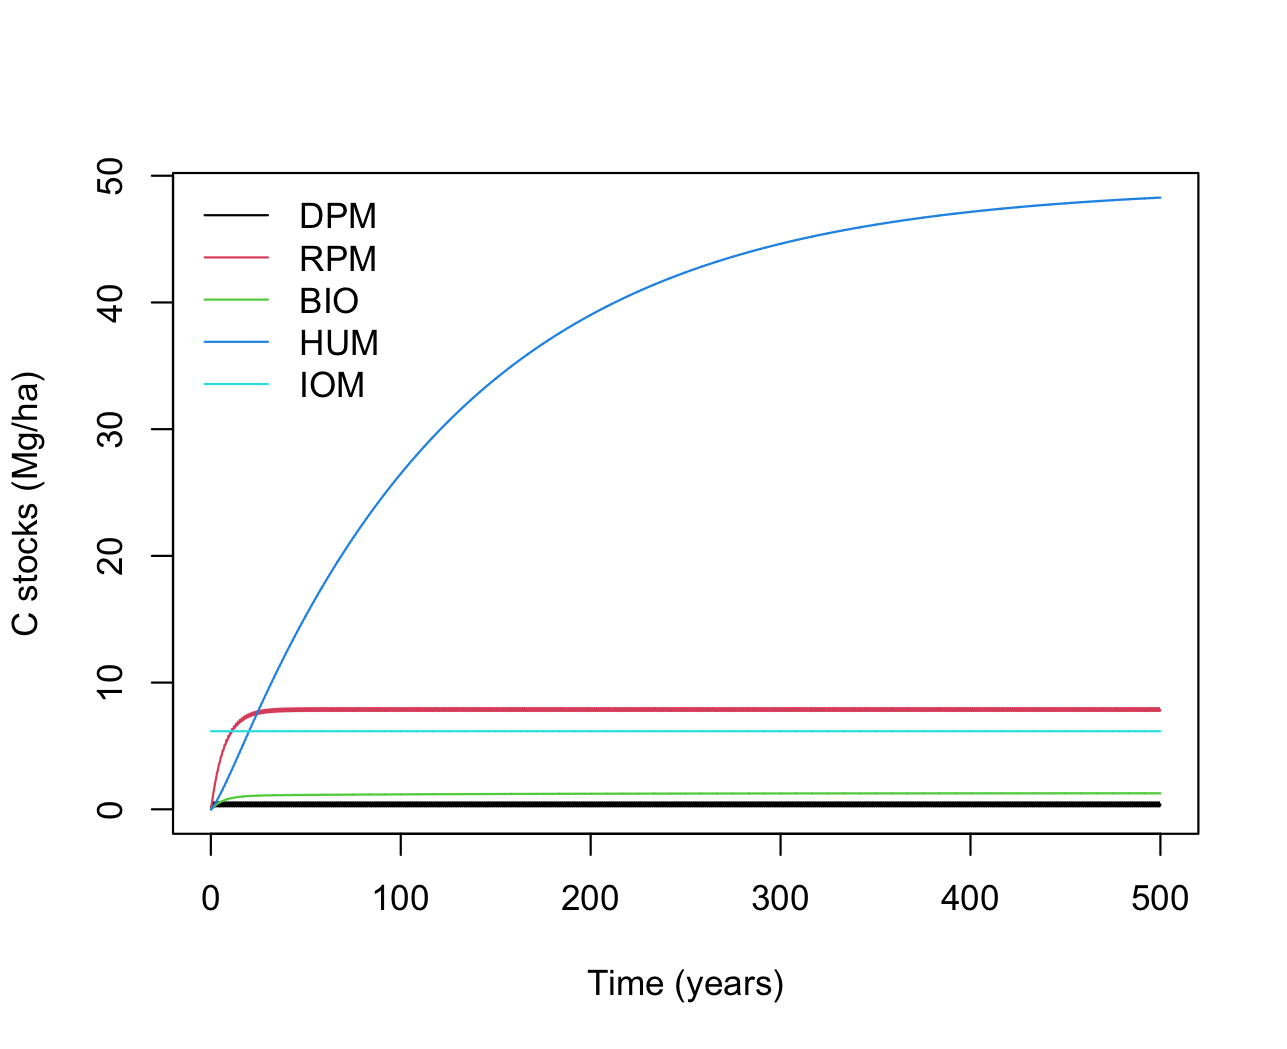

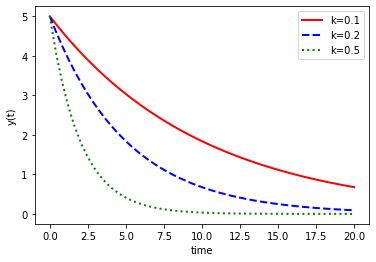

In [150]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
_cont = []
def model(y,t,k):
    _cont.append(t)
    dydt = -k * y
    return dydt

# initial condition
y0 = 5

# time points
t = np.linspace(0,20)

# solve ODEs
k = 0.1
y1 = odeint(model,y0,t,args=(k,))
k = 0.2
y2 = odeint(model,y0,t,args=(k,))
k = 0.5
y3 = odeint(model,y0,t,args=(k,))

# plot results
plt.plot(t,y1,'r-',linewidth=2,label='k=0.1')
plt.plot(t,y2,'b--',linewidth=2,label='k=0.2')
plt.plot(t,y3,'g:',linewidth=2,label='k=0.5')
plt.xlabel('time')
plt.ylabel('y(t)')
plt.legend()
plt.show()

In [152]:
len(_cont)

361

In [153]:
t.shape

(50,)

## End